In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from plotting_tools import * 
import geopandas as gpd

In [2]:
gebiete = gpd.read_file("MunichModel_shape/Gebiete.shp")
abschnitte = gpd.read_file("MunichModel_shape/Abschnitte.shp")
knoten = gpd.read_file("MunichModel_shape/one_point_concentration/konzentrationsverlau_zeitxf.shp")
messstellen = gpd.read_file("MunichModel_shape/Knoten.shp")
knoten["Stoffkonze"] = knoten.Stoffkonze.astype('float')

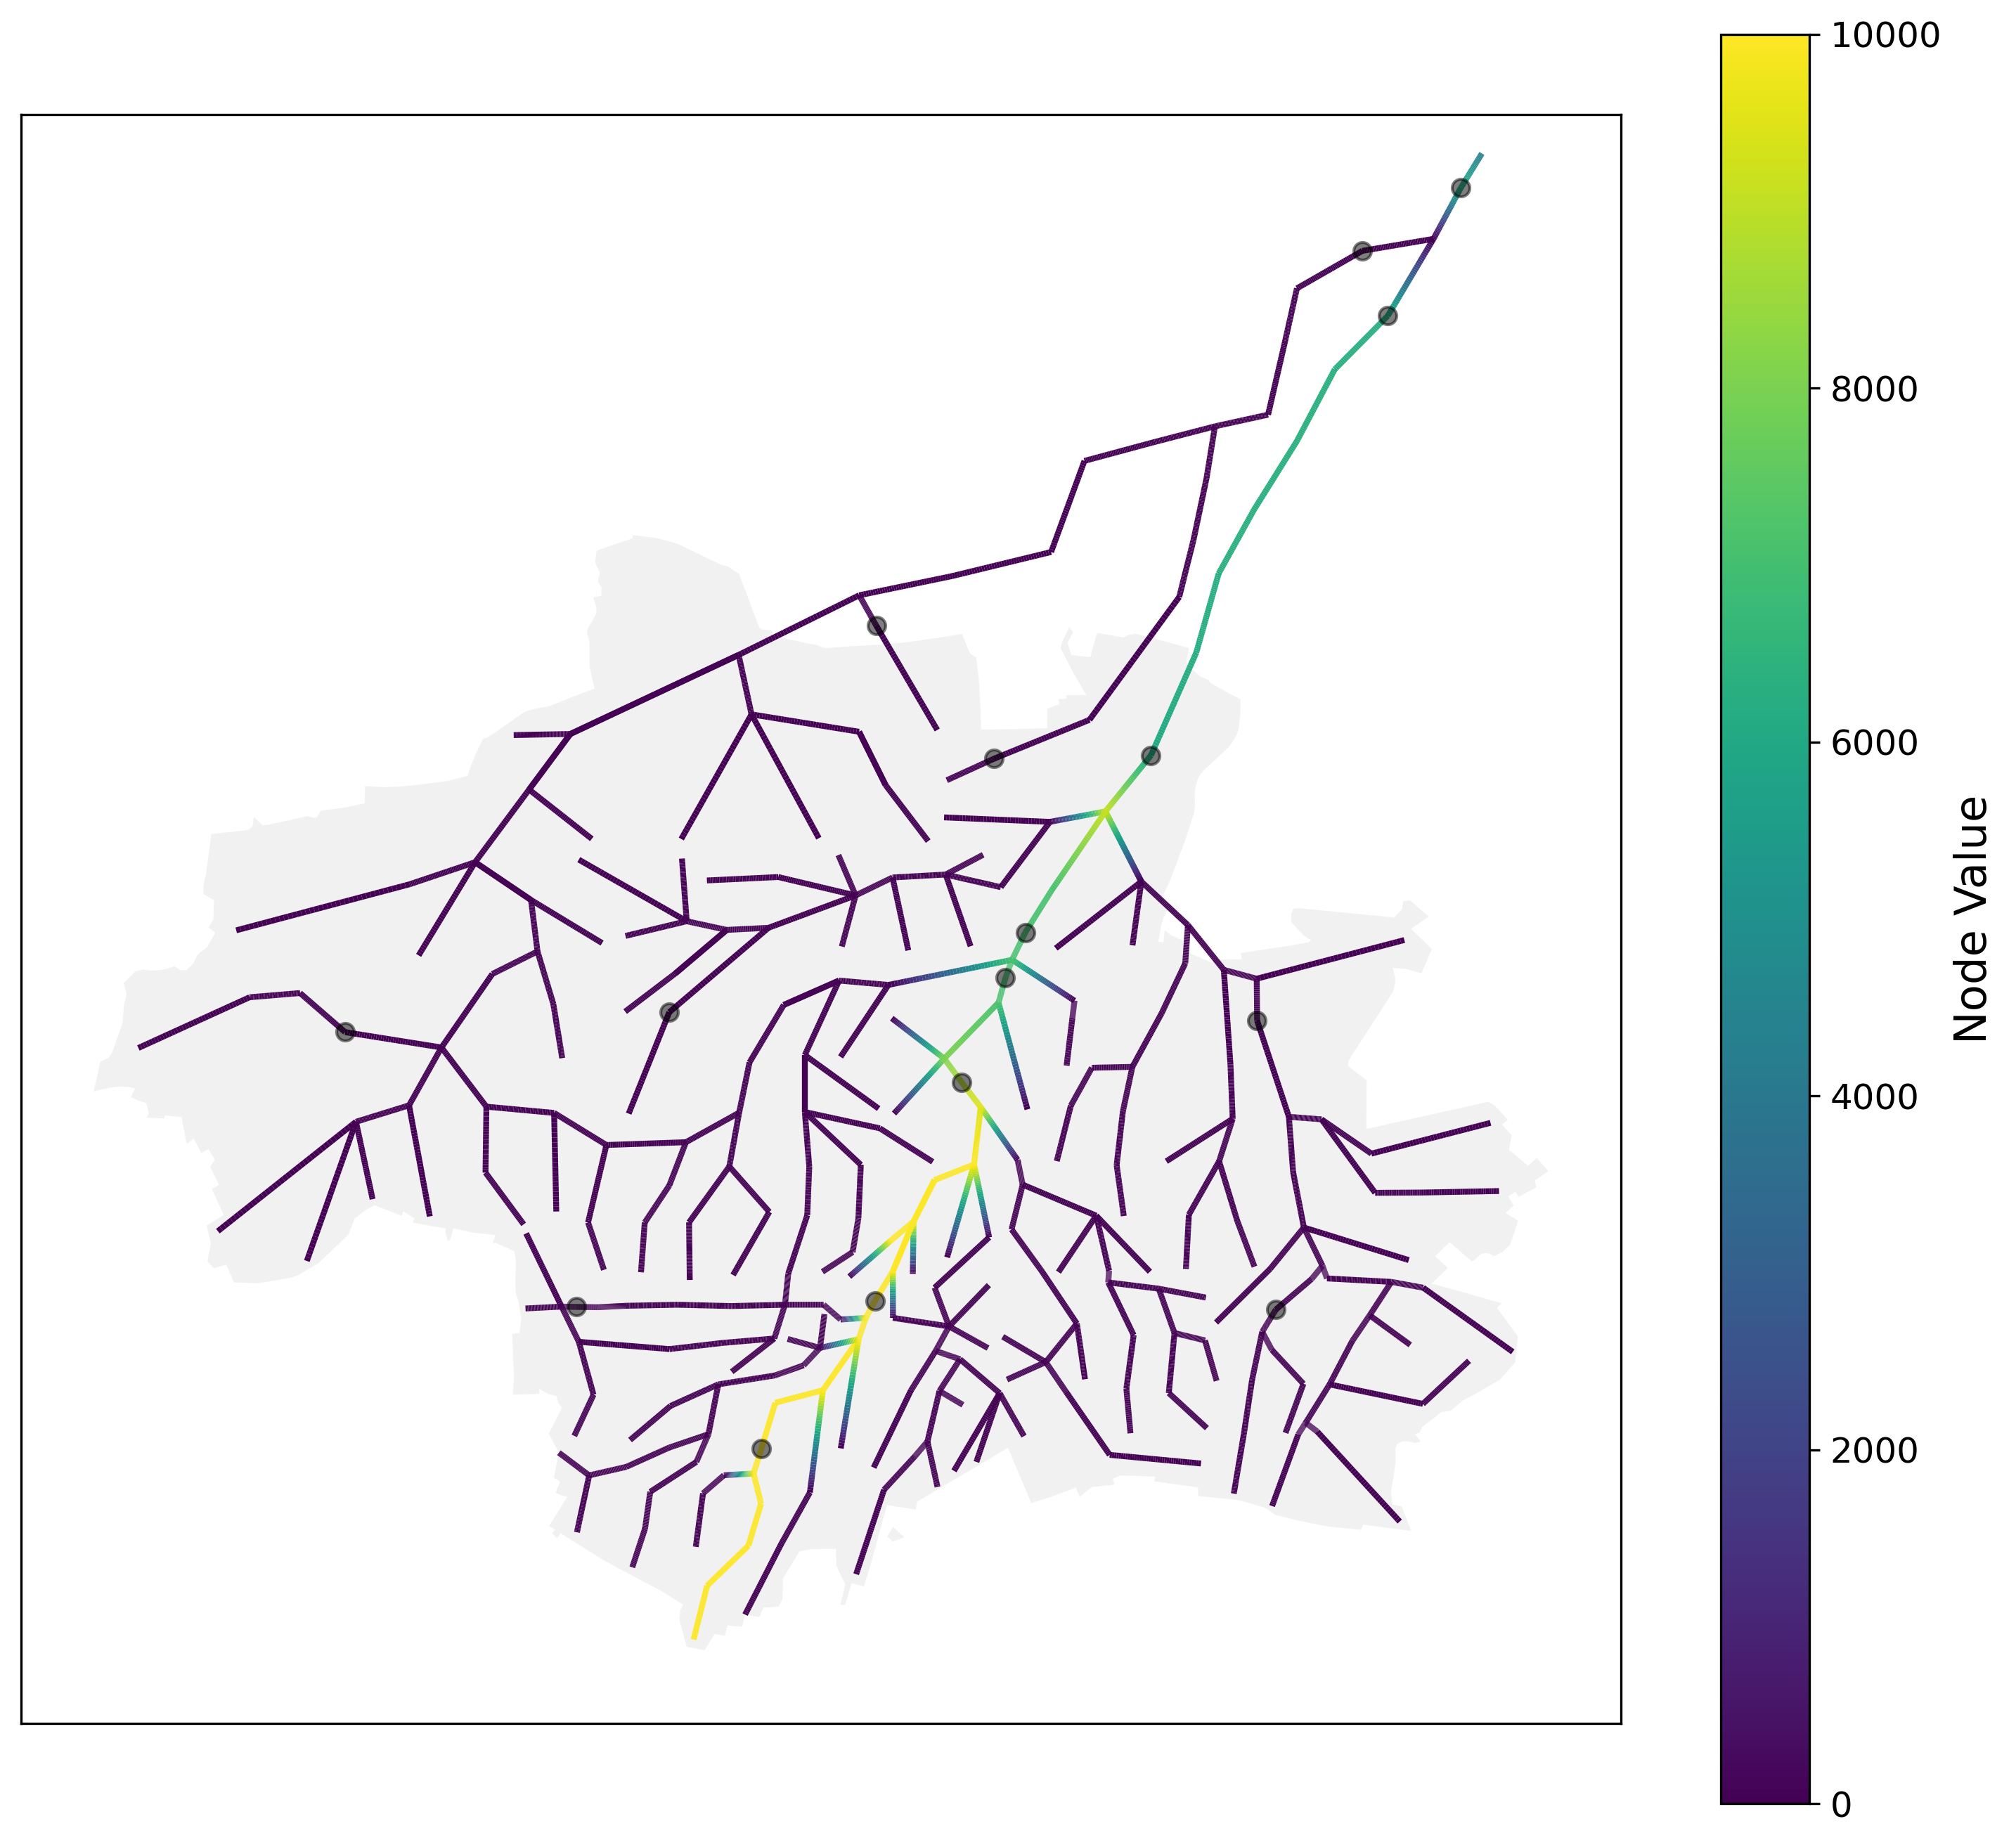

In [6]:
from matplotlib.collections import LineCollection
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from shapely.geometry import Point
from shapely.ops import nearest_points
import numpy as np

# Function to find nearest node
def find_nearest_node(point, knoten_gdf):
    distances = knoten_gdf.geometry.distance(point)
    nearest_idx = distances.idxmin()
    return knoten_gdf.loc[nearest_idx, 'Stoffkonze']


def densify_line(line, num_points=20):
    """Interpolates points along a LineString."""
    return [line.interpolate(float(i)/num_points, normalized=True) for i in range(num_points + 1)]


# Create empty lists for the from/to values
value_from_list = []
value_to_list = []

# Loop through each abschnitt and assign nearest knoten values
for geom in abschnitte.geometry:
    start_point = Point(geom.coords[0])
    end_point = Point(geom.coords[-1])
    
    value_from = find_nearest_node(start_point, knoten)
    value_to = find_nearest_node(end_point, knoten)

    value_from_list.append(value_from)
    value_to_list.append(value_to)

# Assign values to abschnitte
abschnitte['value_from'] = value_from_list
abschnitte['value_to'] = value_to_list

# Plotting
fig, ax = plt.subplots(figsize=(10, 9), dpi=300)
gebiete.plot(ax=ax, color='lightgrey', edgecolor=None, linewidth=0.2, alpha=0.3)
messstellen.plot(ax=ax, color='black', zorder=5, alpha=0.5)

cmap = plt.cm.viridis
norm = mcolors.Normalize(vmin=0, vmax=10000)

for idx, row in abschnitte.iterrows():
    line = row.geometry
    value_start = row['value_from']
    value_end = row['value_to']

    # Densify line
    points = densify_line(line, num_points=40)
    segments = []
    colors = []

    for i in range(len(points) - 1):
        seg = [(points[i].x, points[i].y), (points[i+1].x, points[i+1].y)]
        segments.append(seg)

        interp = i / (len(points) - 2)
        value = (1 - interp) * value_start + interp * value_end
        colors.append(cmap(norm(value)))

    lc = LineCollection(segments, colors=colors, linewidths=2)
    ax.add_collection(lc)

ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("")
ax.set_ylabel("")

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Node Value")

plt.tight_layout()
plt.show()
